#### Moving Beyond Linearity
##### We saw that we can improve upon least squares using ridge regression, the lasso, principal components regression and other techniques.
##### In this setting, the improvement is obtained by reducing the complexity of the linear model and hence the variance of the estimates.
##### In this chapter we relax the linearity assumption while still attempting to maintain as much interpretability as possible
##### Examples of simple extensions of linear models:
##### ***Polynomial regression*** extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power
##### ***Step functions*** cut the range of a variable into ***K*** distinct regions in order to produce a qualitative variable. This has the effect of fitting a piecewise constant function.
##### ***Regression splines*** are more flexible than polynomials and step functions, and in fact are an extension of the two. They involve dividing the range of ***X*** into ***K*** distinct regions. Wihtin each region, a polynomial function is fit to the data. However, these polynomials are contrained so that they join smoothly at the region boundaries, or knots. Provided that the interval is divided into enough regions, this can produce an extremely flexible fit.
##### ***Smoothing splines*** are similar to regression splines, but arise in a slightly different situation. Smoothing splines result from minimizing a residual sum of squares criterion subject to a smoothness penalty.
##### ***Local regression*** is similar to splines, but differs in an important way. The regions are allowed to overlap, and indeed they do so in a very smooth way.
##### ***Generalized additive models*** allow us to extend the methods above to deal with multiple predictors. 

In [1]:
!pip install numpy pandas matplotlib statsmodels

In [2]:
!pip install ISLP

In [3]:
!pip install patsy

In [4]:
!pip install scipy

In [5]:
!pip install pygam

In [6]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import(summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import(s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

#### Polynomial Regression and Step Functions

##### Here we will use the ***Wage*** data as a running example, and show that many of the complex non-linear fitting procedures can easily be implemented in Python.

In [7]:
Wage = load_data("Wage")
y = Wage["wage"]
age = Wage["age"]

In [8]:
#we use the poly() function to create a model matrix that will fit a 4th degree polynomial in age
poly_age = MS([poly("age", degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [9]:
# We now create a grid of values for age at which we want predictions
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({"age": age_grid})

##### We wish to plot the data and add the fit from the 4th degree polynomial. As we will make similar plots, we first write a function to create all the ingredients and produce the plot.
##### Our function takes in a model specification (here a basis specified by a transform), as well as a grid of age values. The function produces a fitted curve as well as 95% confidence bands. 
##### By using an argument for basis we can produce and plot the results with several different transforms, such as splines

In [10]:
# a basis function is any function of your predictors used to construct a more flexible model.
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor= "gray", alpha=0.5) #alpha adds some transparency to the points, provides a visual indication of density
    for val, ls in zip([preds.predicted_mean,
                       bands[:,0],
                       bands[:,1]],
                      ["b", "r--", "r--"]):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Age", fontsize=20)
    ax.set_ylabel("Wage", fontsize=20)
    return ax

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

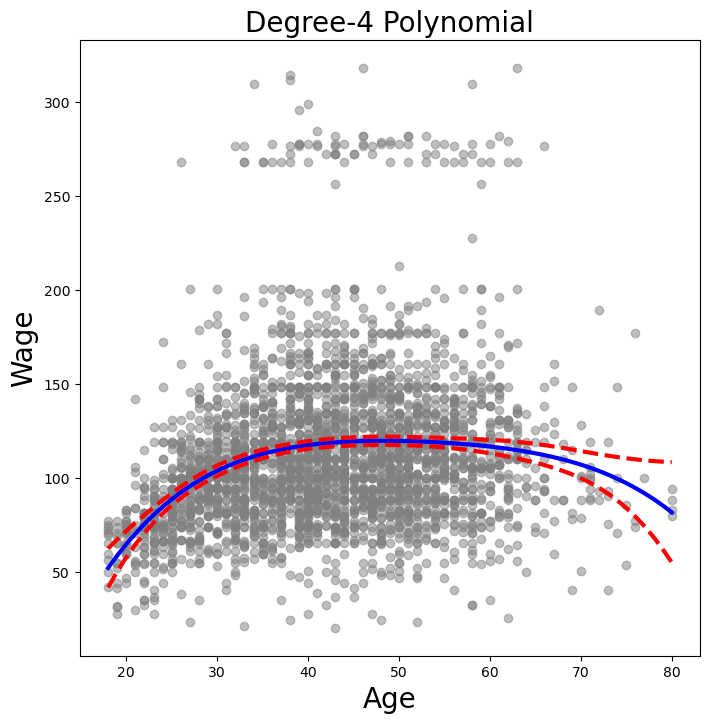

In [11]:
#We now plot the fit of the 4th degree polynomial using this function
plot_wage_fit(age_df, poly_age, "Degree-4 Polynomial")

##### With poly regression we must decide on the degree of the polynomial to use. we can decide in a more systematic way. One way to do this is through hypothesis tests. 
##### We fit a series of models ranging from linear(degree-one) to degree-five polynomials, and look to determine the simplest model that is sufficient to explain the relationship between ***wage*** and ***age***. We use the ***anova_lm()***, which performs a series of ANOVA tests. ANOVA tests the null hypothesis that a model M1 is sufficient to explain the data against the alternative hypothesis that a more complex model M2 is required.
##### The determination is based on an ***F-test***. To perform the test, the models M1 and M2 must be nested: the space spanned by the predictors in M1 must be a subspace of the space spanned by the predictors in M2. In this case, we fit five different polynomial models and sequentially compare the simpler model to the more complex model.

In [12]:
models = [MS([poly("age", degree=d)]) for d in range(1,6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs]) #the * unpacks the list into separate arguments

#the p-value comparing the linear models[0] to the quadratic models[1] is essentially zero indicating that a linear fit is not sufficient, similarly quadratic models[1] comparative  to the cubic models[2] is very low (0.0017), so the quadratic fit is also insufficient

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [13]:
#In this case instead of using the anova() function, we could have obtained these p-values more succinctly by exploiting the fact that poly() creates orthogonal polynomials.
#The raw polynomials are highly correlated with each other : Orthogonal polynomials are re-expression of these poly terms so that each transformed term is uncorrelated with the others
#Two functions pi(x) and pj(x) are orthogonal if their inner product is zero : This means the basis functions dont overlap in the variation they explain

summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [14]:
#Notice that the p-values are the same, and in fact the square of the t-stat are equal to the F-stats from anoval_lm()
(-11.983)**2

143.59228900000002

In [15]:
# The ANOVA method works whether or not we used orthogonal polynomials, provided teh models are nested.
#Example: we can use anova_lm() to compare the following three models, which all have a linear term in education and a poly in age of different degrees
models = [MS(["education", poly("age", degree=d)]) for d in range(1, 4)]
XEs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


##### As an alternative to using hypothesis test and ANOVA, we could choose the polynomial degree using cross-validation.
##### Next we consider the task of predicting whether an individual earns more than 250,000 per year. We proceed much as before, except that first we create the appropriate response vector, and then apply the glm() using the binomial family in order to fit a polynomial logistic regression model.

In [16]:
X = poly_age.transform(Wage)
high_earn = Wage["high_earn"] = y > 250
glm = sm.GLM(high_earn,
            X,
            family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [17]:
#We make the predictions
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

Text(0, 0.5, 'P(Wage > 250)')

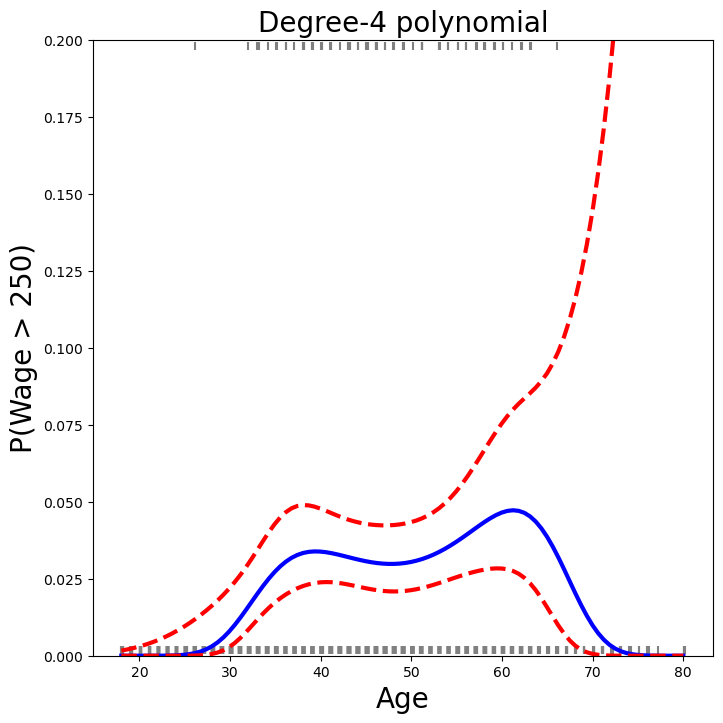

In [18]:
#Lets plot the estimated relationship
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age + 0.2 * rng.uniform(size=y.shape[0]), #jittered ages so the points dont overlap exactly. ***Rug plot***
          np.where(high_earn, 0.198, 0.002), #if the person is a high earner, plot them near y=0.198; else near y=0.002
          fc = "gray",
          marker="|")
for val, ls in zip ([preds.predicted_mean,
                    bands[:, 0],#lower confidence band
                    bands[:, 1]], #upper confidence band
                   ["b", "r--", "r--"]):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title("Degree-4 polynomial", fontsize=20)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylim([0, 0.2])
ax.set_ylabel("P(Wage > 250)", fontsize=20)

In [19]:
# Inorder to fit a step function, we first use the pd.qcut() to discretize age based on quantiles.
#Then we use pd.get_dummies() to create the columns of the model matrix for this categorical variable.
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


#### Splines
##### In order to fit regression splines, we use the transforms from the ISLP package. The actual spline evaluation functions are in the ***scipy.interpolate*** package; here they have been wrapped as transforms similar to Poly() and PCA().

##### We saw earlier that regression splines can be fit by constructing an appropriate matrix of basis functions. The ***BSpline()*** function generates the entire matrix of basis functions for splines with the specified set of knots. By default the B-splines produced are cubic. To change the degree, use the argument ***degree***

In [20]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age= bs_.transform(age)
bs_age.shape


(3000, 7)

In [21]:
# We can form this same matrix using the bs() object, which facilitates adding this to a model-matrix builder
# We now fit a cubic spline model to the Wage data
bs_age= MS([bs("age", internal_knots=[25,40,60], name="bs(age)")])
Xbs= bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

#Notice that there are 6 spline coeffs rather than 7. This is because, by default, bs() assumes intercept=False, since we typically have an overall intercept in the model.
#So it generates the spline basis with the given knots, and then discards one of the basis functions to account for the intercept.




,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


##### We could also use ***df***(degrees of freedom) option to sepcify the complexity of the spline. We see above that with 3 knots, the spline basis has 6 columns or degrees of freedom.
##### When we specify ***df=6*** rather than the actual knots, ***bs()*** will produce a spline with 3 knots chosen at uniform quantiles of the training data.

In [22]:
BSpline(df=6).fit(age).internal_knots_

#When asking for 6 degrees of freedom, the transform chooses knots at ages 33.75, 42.0 and 51.0 which correspond to the 25th, 50th and 75th percentiles of age.

array([33.75, 42.  , 51.  ])

##### When using B-splines we need not limit ourselves to cubic polynomials(degree=3). For instance using degree=0 results in piecewise constant functions.
##### Note: ***df = number of internal knots + degree + 1***

In [23]:
bs_age0 = MS([bs("age",
                df=3,
                degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


##### In order to fit a natural spline, we use the ***NaturalSpline()*** transform with the corresponding helper ***ns()***

In [24]:
#Fit a natural spline with 5 df(excluding the intercept) and plot the results
ns_age = MS([ns("age", df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


<Axes: title={'center': 'Natural spline, df=5'}, xlabel='Age', ylabel='Wage'>

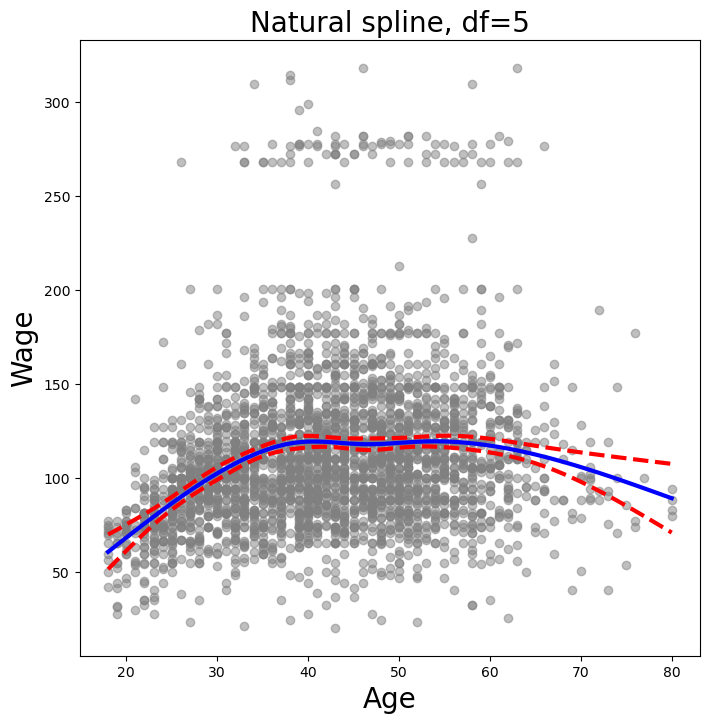

In [25]:
#we now plot the natural spline using our plotting function
plot_wage_fit(age_df, ns_age, "Natural spline, df=5")

#### Smoothing Splines and GAMs
##### A smoothing spline is a special case of a GAM with squared-error loss and a single feature. To fit GAMs in Python we will use the pygam package.
##### The estimator LinearGAM() uses squared-error loss. The GAM is specified by associating each column of a model matrix with a particular smoothing operation: ***s*** for smoothing spline; ***l*** for linear, and ***f*** for factor or categorical variables.
##### The argument ***0*** passed to ***s*** below indicates that this smoother will apply to the first column of a feature matrix. The argument ***lam*** is the penalty parameter lambda.

In [26]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

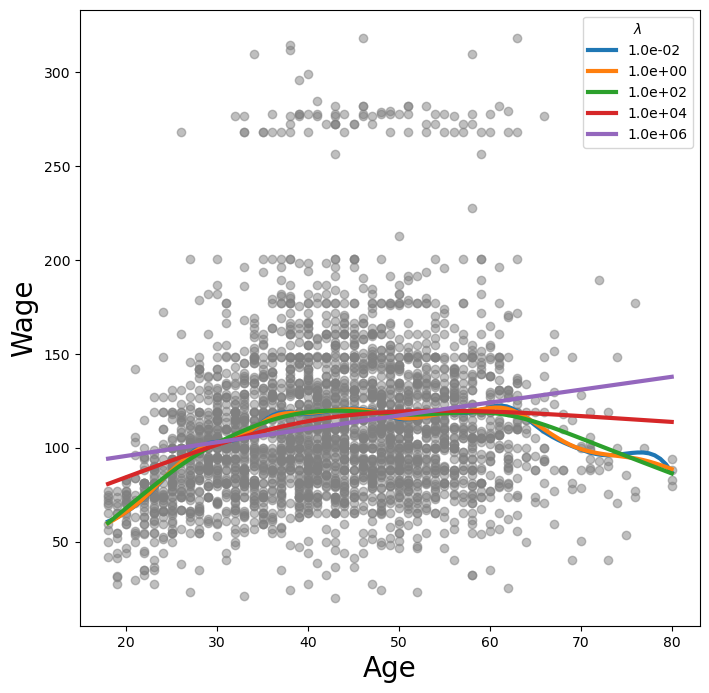

In [27]:
#Lets investigate how the fit changes with the smoothing parameter lam.
#The function np.logspace() is similar to np.linspace() but spaces points evenly on the log-scale. Below we vary lam from 10^-2 to 10^6
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor="gray", alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
           gam.predict(age_grid),
           label = "{:.1e}".format(lam),
           linewidth=3)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Wage", fontsize=20)
ax.legend(title="$\lambda$")

##### The Pygam package can perform a search for an optimal smoothing parameter.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


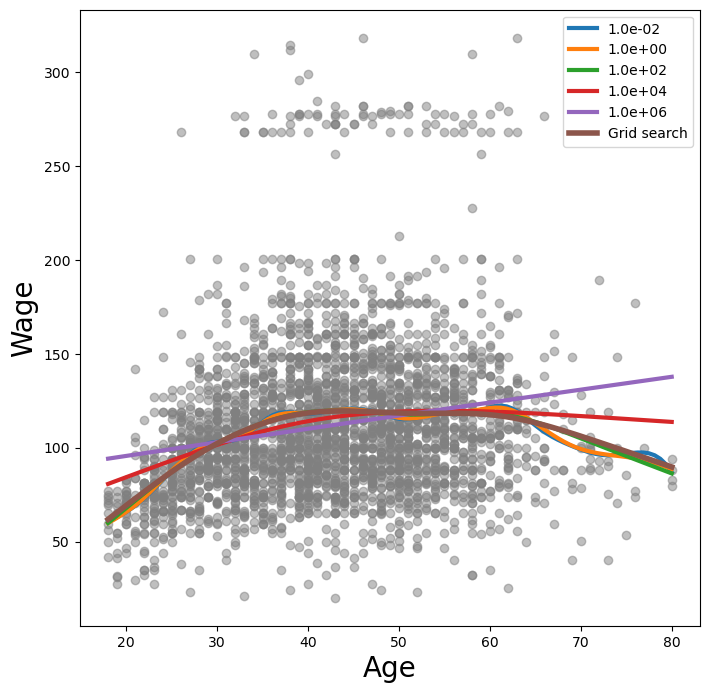

In [28]:
gam_opt = gam.gridsearch(X_age, y) #searches over a grid of smoothing parameters(lam) to find the best one by cross-validation
ax.plot(age_grid,
        gam_opt.predict(age_grid), #predicted wages for each point in age_grid
        label= "Grid search",
        linewidth=4)
ax.legend()
fig

##### Alternatively, we can fix the degrees of freedom of the smoothing spline using a function included in the ISLP.pygam package.
##### Below we find a value of lambda that gives us roughly four degrees of freedom. We note that these degrees of freedom include the unpenalized intercept and linear term of the smoothing spline, hence there are at least two degrees of freedom.

##### What a smoothing spline is: in GAM when you specify ***s_gam(0)***- this creates a smoothing spline basis for the first predictor.
##### That spline basis has two parts:
##### ***1. Unpenalized part***: The constant(intercept), the linear function of x---These are always included and not penalized by λ .
##### ***2. Penalized wiggles***: the higher-order, non-linear spline basis functions-- These are penalized by the smoothing parameter
##### The unpenalized intercept + linear component mean that even if λ is set very large(forcing the curve to be smooth as possible), the model can still fit a straight line
##### That straight line requires 2df: one for the intercept and one for the slope.

In [29]:
age_term = gam.terms[0]
lam_4= approx_lam(X_age, age_term, 4) #this asks what value of lam would give this term approximately 4 degrees of freedom
age_term.lam= lam_4 #so now lam_4 is the λ value that makes the spline behave as if it has ~4df
degrees_of_freedom(X_age, age_term) #computes the effective degrees of freedom of the spline term given the chosen λ. Effective df is not just "number of basis functions"- it is smaller if smoothing is heavy because wiggliness is penalized 



4.0000001000038585

In [30]:
gam.statistics_["edof"] 

5.643966820928215

##### Lets vary the degrees of freedom in a similar plot to above. We choose the degrees of freedom as the desired dof plus 1 to account for the fact that these smoothing splines always have an intercept term.

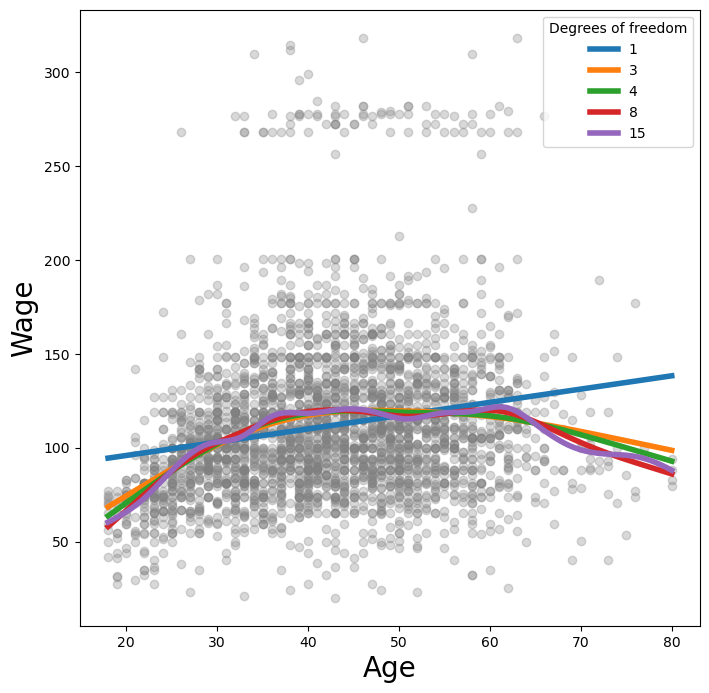

In [31]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age, y, fc="gray", alpha=0.3)
for df in [1,3,4,8,15]:
    lam= approx_lam(X_age, age_term, df+1)
    age_term.lam=lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
           gam.predict(age_grid),
           label= "{:d}".format(df),
           linewidth=4)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Wage", fontsize=20)
ax.legend(title="Degrees of freedom")

#### Additive Models with Several Terms

##### The strength of generalized additive models lies in their ability to fit multivariate regression models with more flexibility than linear models. We demonstrate two approaches: the first in a more manual fashion using natural splines and piecewise constant functions, and the second using the pygam package and smoothing splines.
##### We now fit a GAM by hand to predict ***wage*** using natural spline functions of ***year*** and ***age***, treating ***education*** as a qualitative predictor. Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the ***sm.OLS()*** function.
##### We will build the model matrix in a more manual fashion here, since we wish to access the pieces separately when constructing partial dependence plots.

In [32]:
ns_age= NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage["year"])
Xs = [ns_age.transform(age),
     ns_year.transform(Wage["year"]),
     pd.get_dummies(Wage["education"]).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

## Here the function NaturalSpline() is the workhorse supporting the ns() helper function. We chose to use all columns of the indicator matrix for the categorical variable education, making an intercept redundant.
## Finally we stacked the three component matrices horizontally to form the model matrix X_bh

##### We now show how to construct partial dependence plots for each of the terms in our rudimentary GAM. We can do this by hand, given grids for ***age*** and ***year***.
##### We simply predict with new X matrices, fixing all but one of the features at a time.

Text(0.5, 1.0, 'Partial dependence of age on wage')

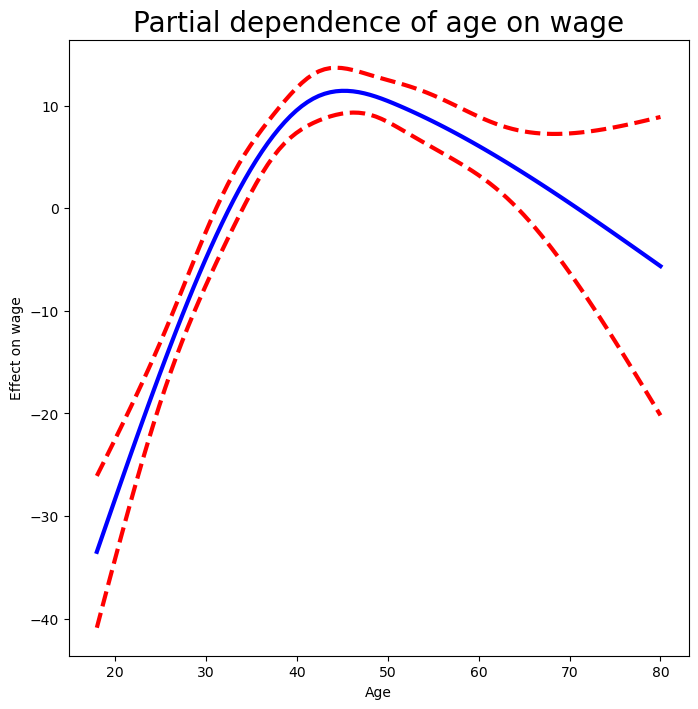

In [33]:
age_grid = np.linspace(age.min(), age.max(), 100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age= preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, "b", linewidth=3)
ax.plot(age_grid, bounds_age[:,0], "r--", linewidth=3)
ax.plot(age_grid, bounds_age[:,1], "r--", linewidth=3)
ax.set_xlabel("Age")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of age on wage", fontsize=20)

#The idea is to create a new prediction matrix, where all but the columns belonging to age are constant(set to their training-data means).
#The four columns for age are filled in with the natural spline basis evaluated at the 100 values in age_grid.

#Centering :: The partial effect of age is relative, not absolute.
#If you dont center, the plot would include the intercept and contributions from other terms.
#By subtracting the mean, you center the curve around zero - so the y-axis shows the deviation from average wage explained by age alone.
# Value above 0 means age increases predicted wage compared to the overall average.
#Value below 0 means age decreases predicted wage compared to the average.

##### Effect of ***year*** on ***wage***

Text(0.5, 1.0, 'Partial dependence of year on wage')

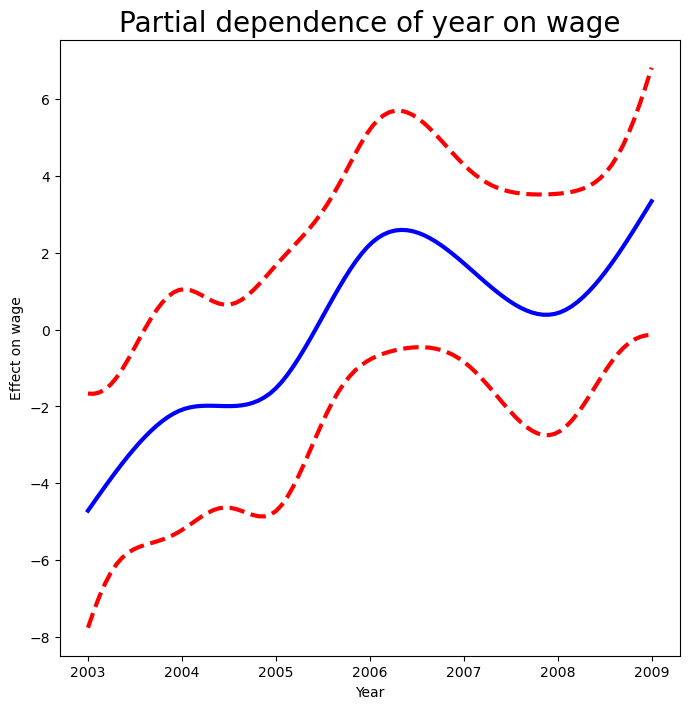

In [34]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage["year"].min(),
                       Wage["year"].max(),
                       100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:]= X_bh[:].mean(0)[None,:]
X_year_bh[:, 4:9]= ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, "b", linewidth=3)
ax.plot(year_grid, bounds_year[:,0], "r--", linewidth=3)
ax.plot(year_grid, bounds_year[:,1], "r--", linewidth=3)
ax.set_xlabel("Year")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of year on wage", fontsize=20)

##### We now fit the model using the smoothing splines rather than natural splines. All of the terms are fit simultaneously, taking each other into account to explain the response.
##### The pygam package only works with matrices, so we must convert the categorical series education to its array representation, which can be found with the ***cat.codes*** attribute of ***education***. As ***year*** only has 7 unique values, we use only seven basis functions for it.

In [35]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0))
Xgam = np.column_stack([age, 
                       Wage["year"],
                       Wage["education"].cat.codes])
gam_full = gam_full.fit(Xgam, y)

#The two s_gam() terms results in smoothing spline fits, and use a default value for lambda(lam=0.6), which is somewhat arbitrary.
# For the categorical term education, specified using a f_gam() term, we specify lam=0 to avoid any shrinkage.

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

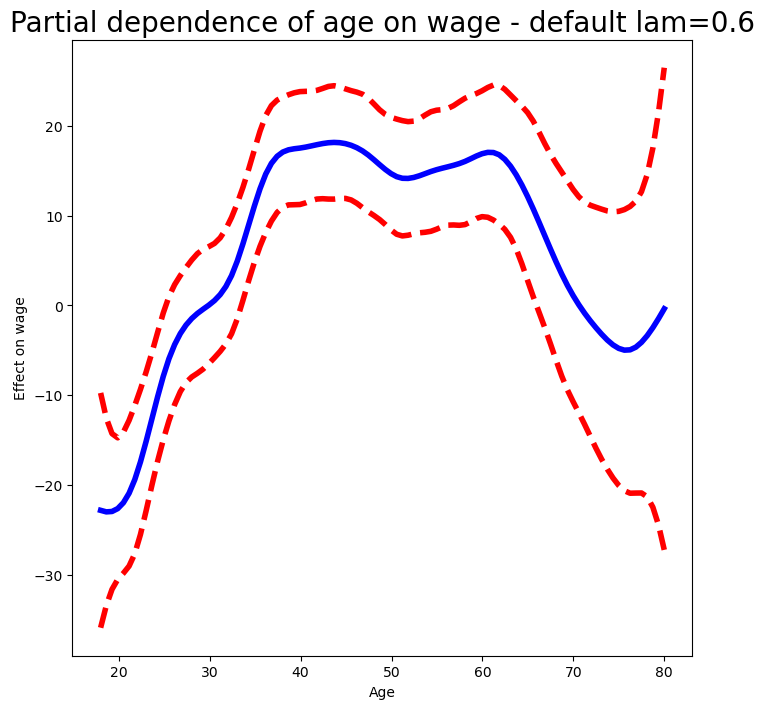

In [36]:
# We produce the partial dependence plot in age to see the effect of these choices.
#The values for the plot are generated by the pygam package. we use plot_gam() for partial-dependence plots in ISLP.pygam

fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel("Age")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of age on wage - default lam=0.6", fontsize=20)

##### We see that the function above is somewhat wiggly. It is more natural to specify the ***df*** than a value of ***lam***. We refit a GAM using four degrees of freedom each for age and year.
##### Recall that the addition of one below takes into account the intercept of the smoothing spline.

In [37]:
age_term = gam_full.terms[0]
age_term.lam= approx_lam(Xgam, age_term, df=4+1)
year_term= gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

#Note that updating age_term.lam above updates it in gam_full.terms[0] likewise for year_term.lam

Text(0.5, 1.0, 'Partial dependence of year on wage')

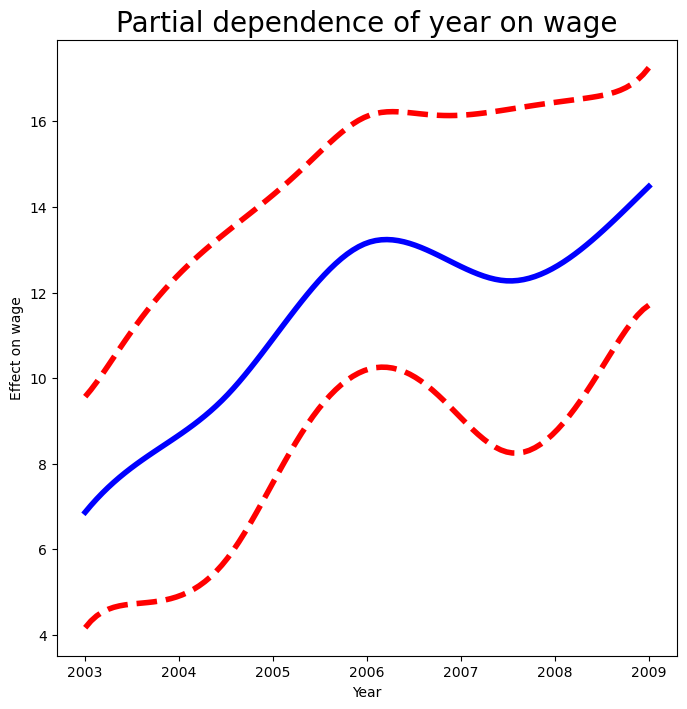

In [38]:
#repeating the plot for age, we see that it is much smoother.
#We produce the plot for the year
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of year on wage", fontsize=20)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

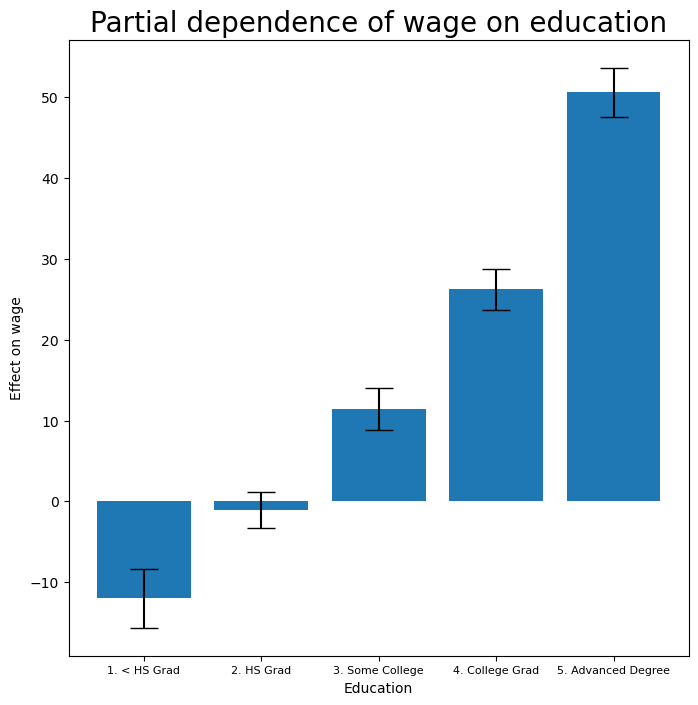

In [39]:
#we plot education which is categorical
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel("Education")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of wage on education", fontsize=20)
ax.set_xticklabels(Wage["education"].cat.categories, fontsize=8)

#### ANOVA Tests for Additive Models

##### In all our models, the function of ***year*** looks rather linear. We can perform a series of ANOVA tests in order to determine which of these three models is best: a GAM that exludes ***year(M1)***, a GAM that uses a linear function of ***year(M2)***, or a GAM that uses spline function of ***year(M3)***.

In [40]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)

gam_linear = LinearGAM(age_term + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [41]:
#To directly assess the effect of year we run ANOVA on three models fit above
anova_gam(gam_0, gam_linear, gam_full)

# We find that there is compelling evidence that a GAM with a linear function in year is better than a GAM that does not include year at all (p-value=0.002)
# However there is no evidence that a non-linear function of year is needed (p-value=0.435). Therefore based on this resukts the ANOVA M2 is preferred.

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


##### We can repeat the same process for ***age*** as well. We see there is very clear evidence that non-linear term is required for age.

In [42]:
gam_0 = LinearGAM(year_term + f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) + year_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [43]:
# verbose summary() method for the GAM fit
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\colli\AppData\Local\Temp\ipykernel_24128\543406986.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [44]:
# Lets make predictions from gam objects.
#here we make predictions on the training set
Yhat= gam_full.predict(Xgam)

##### To fit a logistic regression GAM, we use ***LogisticGAM()*** from ***pygam***

In [45]:
gam_logit = LogisticGAM(age_term + l_gam(1, lam=0) + f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

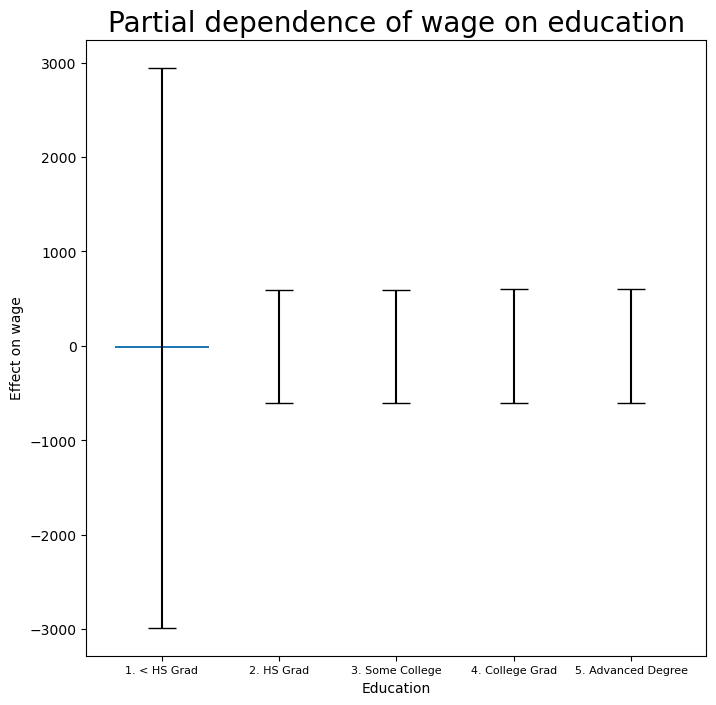

In [46]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel("Education")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of wage on education", fontsize=20)
ax.set_xticklabels(Wage["education"].cat.categories, fontsize=8)

In [47]:
#The model seems to be very flat, with especially high error bars for the first category.
#Lets look at the data a bit more closely
pd.crosstab(Wage["high_earn"], Wage["education"])


education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


##### We see that there are no high earners in the first category of education, meaning that the model will have a hard time fitting. 
##### We will fit a logistic regression GAM excluding all observations falling into this category. This provides more sensible results.
##### To do so, we could subset the model matrix, though this will not remove the column from Xgam. While we can deduce which column corresponds to this feature, for reproducibility's sake we reform the model matrix on this smaller subset.

In [48]:
only_hs = Wage["education"] == "1. < HS Grad"
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_["age"],
                        Wage_["year"],
                        Wage_["education"].cat.codes-1]) #-1  due to a bug in pygam
high_earn_ = Wage_["high_earn"]

#we now fit the model
gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

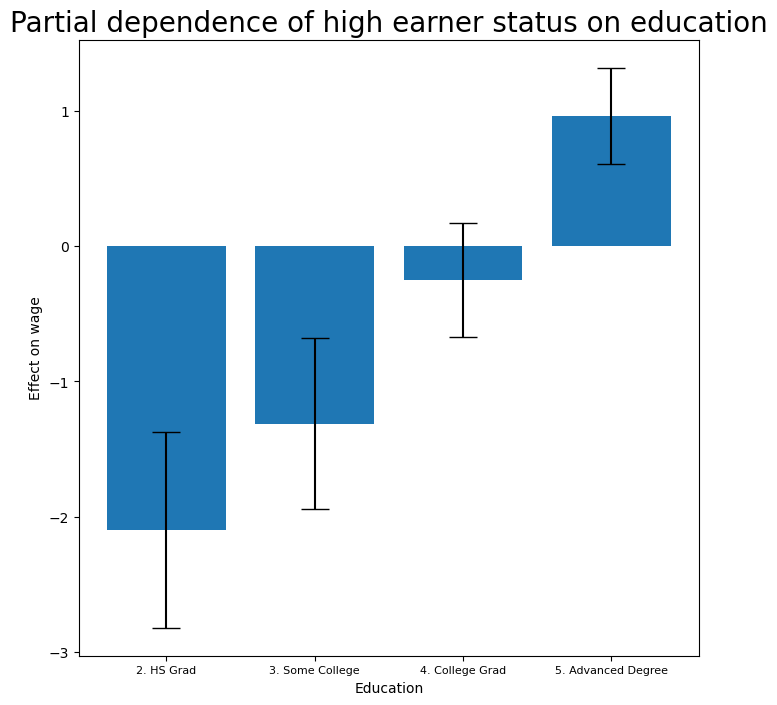

In [49]:
#Lets look at the effect of education, year, and age on high earner status now that we've removed those observations
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel("Education")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of high earner status on education", fontsize=20)
ax.set_xticklabels(Wage["education"].cat.categories[1:], fontsize=8)

Text(0.5, 1.0, 'Partial dependence of high earner status on year')

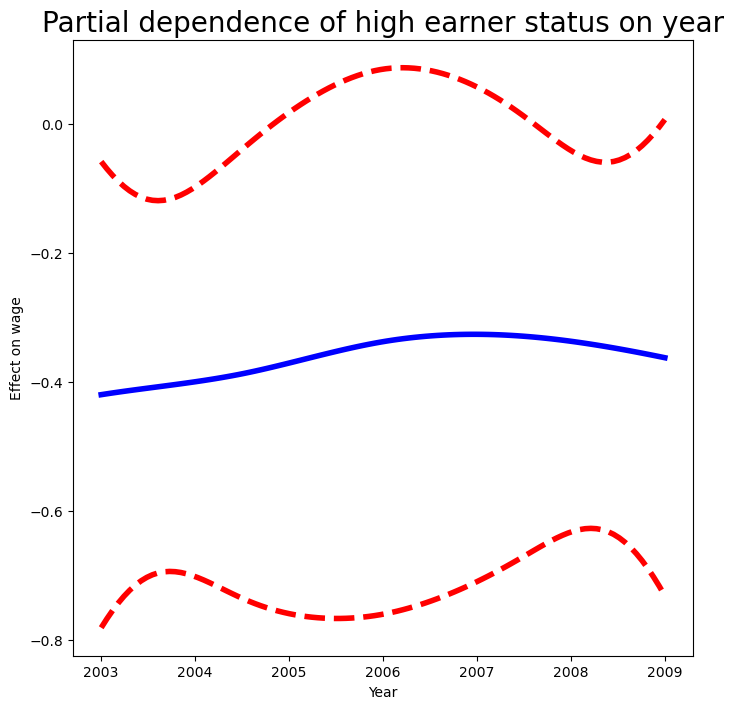

In [50]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel("Year")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of high earner status on year", fontsize=20)

Text(0.5, 1.0, 'Partial dependence of high earner status on age')

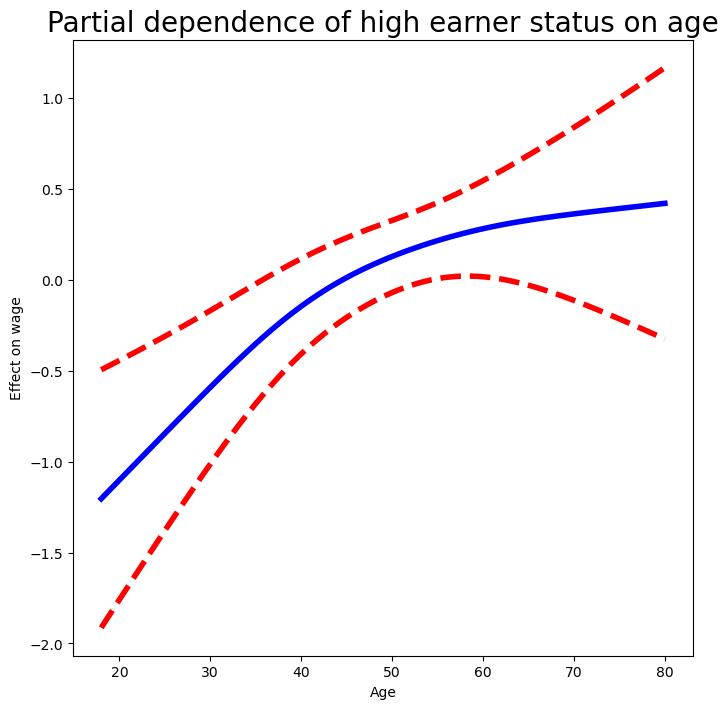

In [51]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel("Age")
ax.set_ylabel("Effect on wage")
ax.set_title("Partial dependence of high earner status on age", fontsize=20)

#### Local Regression

##### Here we illustrate the use of local regression using the ***lowess()*** function from ***sm.nonparametric***. Some implementations of GAMs allow terms to be local regression operators: this is not the case in ***pygam***.
##### Here we fit local linear regression models using spans of 0.2 and 0.5; that is, each neighborhood consists of 20% or 50% of the observations. As expected, using a span of 0.5 is smoother than 0.2

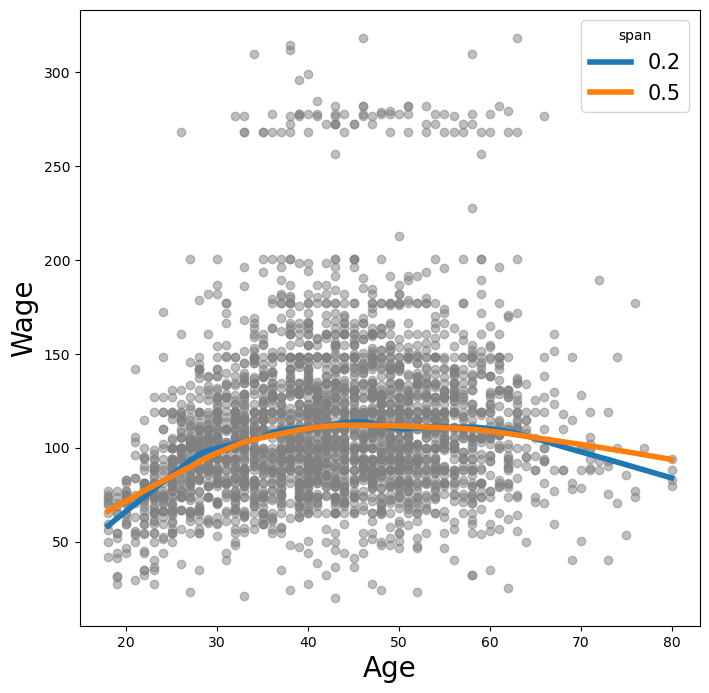

In [52]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor="gray", alpha=0.5)
for span in [0.2, 0.5]:
    fitted= lowess(y, age, frac=span, xvals=age_grid)
    ax.plot(age_grid, fitted, label="{:.1f}".format(span), linewidth=4)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Wage", fontsize=20)
ax.legend(title="span", fontsize=15)

#### Question 1
##### In this exercise, you will further analyze the ***Wage*** dataset.
##### ***(a)*** Perform polynomial regression to predict ***wage*** using ***age***. Use cross-validation to select the optimal degree d for the polynomial. What degreee was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [53]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline


In [54]:
Wage = load_data("Wage")
# Predictor and response
X = Wage[['age']].values
y = Wage['wage'].values

degrees = np.arange(1, 10)
cv_scores = []

kf = KFold(n_splits=10, shuffle=True, random_state=1)

for d in degrees:
    # Pipeline: scale → polynomial expansion → linear regression
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=d, include_bias=False),
        LinearRegression()
    )
    
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    cv_scores.append(-scores.mean())

best_degree = degrees[np.argmin(cv_scores)]
print("Best polynomial degree:", best_degree)


Best polynomial degree: 9


In [55]:
Xs = []
models= []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)
    #scale each polynomial term
    scaler= StandardScaler()
    X_poly_scaled = scaler.fit_transform(X_poly)
    #add intercept for statsmodels
    X_poly_sm = sm.add_constant(X_poly_scaled)
    #save design matrix
    Xs.append(X_poly_sm)
    #fit model
    model= sm.OLS(y, X_poly_sm).fit()
    models.append(model)
#perform ANOVA comparison
anova_results = anova_lm(*models)
anova_results

#interpretation
# Degree 1 - 2 : huge improvement(F=144). A quadratic term is highly significant
# Degree 2 - 3 : still significant. A cubic term adds value

## ANOVA conclusion_ evidence strongly supports up to degree 3 and could justify degree 4. Beyond 4 improvements are tiny
## CV: chose degree 9 because it minimized predictive error.



,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.811827,2.128079e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.903818,1.665559e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.815616,5.086990e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.806202,3.693177e-01
5,2993.0,4.766389e+06,1.0,3932.257665,2.471765,1.160134e-01
6,2992.0,4.763834e+06,1.0,2555.281281,1.606216,2.051232e-01
7,2991.0,4.763707e+06,1.0,126.668985,0.079622,7.778293e-01
8,2990.0,4.756703e+06,1.0,7004.317147,4.402820,3.596326e-02


Text(0.5, 1.0, 'Polynomial Regression Fit(degree=9)')

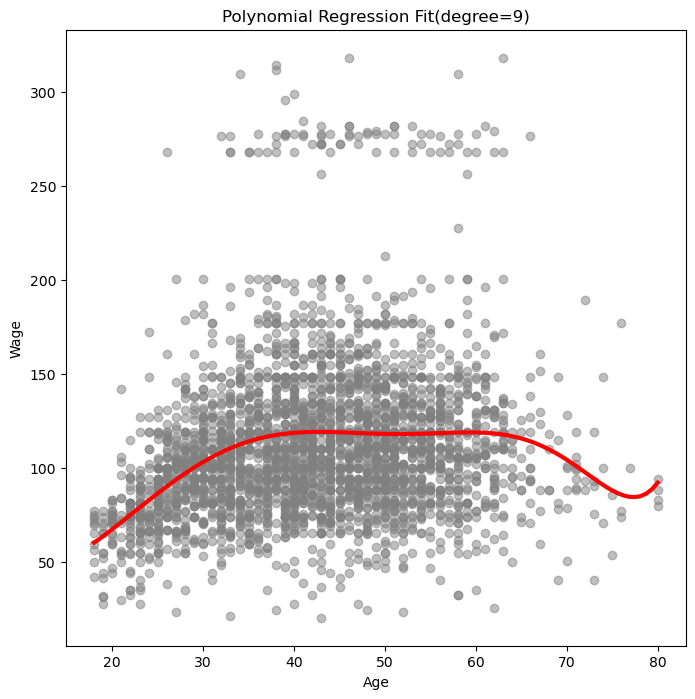

In [57]:
#plot of the resulting polynomial fit to the data
#Fit and plot best polynomial
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly= poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)

#Grid for smooth plotting
age_grid = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
y_pred = model.predict(poly.transform(age_grid))
fig, ax = subplots(figsize=(8,8))
ax.scatter(X, y, facecolor="gray", alpha=0.5)
ax.plot(age_grid, y_pred, color="red", linewidth=3)
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.set_title(f"Polynomial Regression Fit(degree={best_degree})")


##### ***(b)***. Fit a step function to predict ***wage*** using ***age***, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

Text(0.5, 1.0, 'Step Function Fit(cuts=8)')

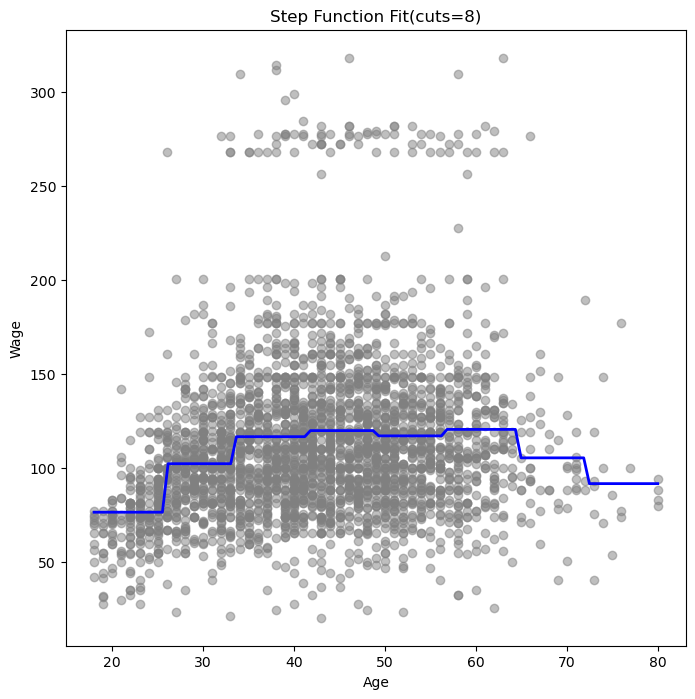

In [62]:
#Here we cut age into bins and fit a regression. The optimal number of cuts is chosen via CV
from sklearn.preprocessing import KBinsDiscretizer
cuts = np.arange(2,11)
cv_scores_step = []

for c in cuts:
    discretizer = KBinsDiscretizer(n_bins=c, encode= "onehot-dense", strategy="uniform")
    X_step = discretizer.fit_transform(X)
    model = LinearRegression()
    scores = cross_val_score(model, X_step, y, cv=kf, scoring="neg_mean_squared_error")
    cv_scores_step.append(-scores.mean())
best_cuts = cuts[np.argmin(cv_scores_step)]   
#best_cuts
#Fit with the best cut
disc= KBinsDiscretizer(n_bins=best_cuts, encode="onehot-dense", strategy="uniform")
X_step = disc.fit_transform(X)
model_step = LinearRegression().fit(X_step, y)
#predictions
y_pred_step = model_step.predict(disc.transform(age_grid))
#plotting
fig, ax = subplots(figsize=(8,8))
ax.scatter(X, y, fc="gray", alpha=0.5)
ax.plot(age_grid, y_pred_step, "b", linewidth=2)
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.set_title(f"Step Function Fit(cuts={best_cuts})")


##### ***Question 2***
##### This questionn relates to the ***College*** data set
##### ***(a)*** Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [77]:
from sklearn.model_selection import train_test_split
College= load_data("College")
y= College["Outstate"]
X = College.drop("Outstate", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object')

In [69]:
!pip install mlxtend

In [100]:
#since sklearn doesnt have built-in stepwise regression we will us mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import OneHotEncoder
#base model
#lin_reg = LinearRegression()
#forward stepwise selection
#sfs = SFS(
    #lin_reg,
    #k_features="best",
    #forward=True,
   # floating= False,
  #  scoring="neg_mean_squared_error",
 #   cv=5
#)
#sfs= sfs.fit(X_train, y_train)
#print("Selected features:", sfs.k_feature_names_)

### The above code doesnt work beacuse we have categorical variables
#First convert categorical variables to numerical
#Identify categorical columns(those with string values like Yes)
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
#apply one-hot encoding to categorical columns
if len(categorical_cols)>0:
    #create a one-hot encoder
    encoder= OneHotEncoder(sparse_output=False, drop="first")
    #apply encoding to categorical columns
    encoded_data= encoder.fit_transform(X_train[categorical_cols])
    #create DF with the encoded data
    encoded_df=pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index= X_train.index)
    #drop original categorical columns and add encoded ones
    X_train_encoded = X_train.drop(columns=categorical_cols).join(encoded_df)
else:
    X_train_encoded= X_train.copy()
#now use the encoded data for feature selection
lin_reg= LinearRegression()
#forward stepwise selection
sfs= SFS(lin_reg, k_features="best", forward=True, floating=False, scoring= "neg_mean_squared_error", cv=5)
sfs= sfs.fit(X_train_encoded, y_train)
print("Selected features:", sfs.k_feature_names_)

Selected features: ('Apps', 'Accept', 'Top10perc', 'F.Undergrad', 'P.Undergrad', 'Room.Board', 'Personal', 'PhD', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate', 'Private_Yes')


##### ***(b)*** Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

In [114]:
selected_features = list(sfs.k_feature_names_)
X_train_sel= X_train[selected_features]
X_test_sel = X_test[selected_features]
gam = LinearGAM().fit(X_train_sel, y_train)

In [115]:
from pygam import LinearGAM, s, f
# Let us make sure the categorical variables are one-hot encoded before feature selection and before GAM
#one-hot encode Private
College_enc = pd.get_dummies(College, drop_first=True)
y= College_enc["Outstate"]
X= College_enc.drop("Outstate", axis=1)
#train/test split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=2)
#feature selection
lin_reg= LinearRegression()
sfs= SFS(lin_reg, k_features="best", forward=True, floating=False, scoring="neg_mean_squared_error")
sfs = sfs.fit(X_train, y_train)
selected_features=list(sfs.k_feature_names_)
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
gam = LinearGAM().fit(X_train_sel, y_train)


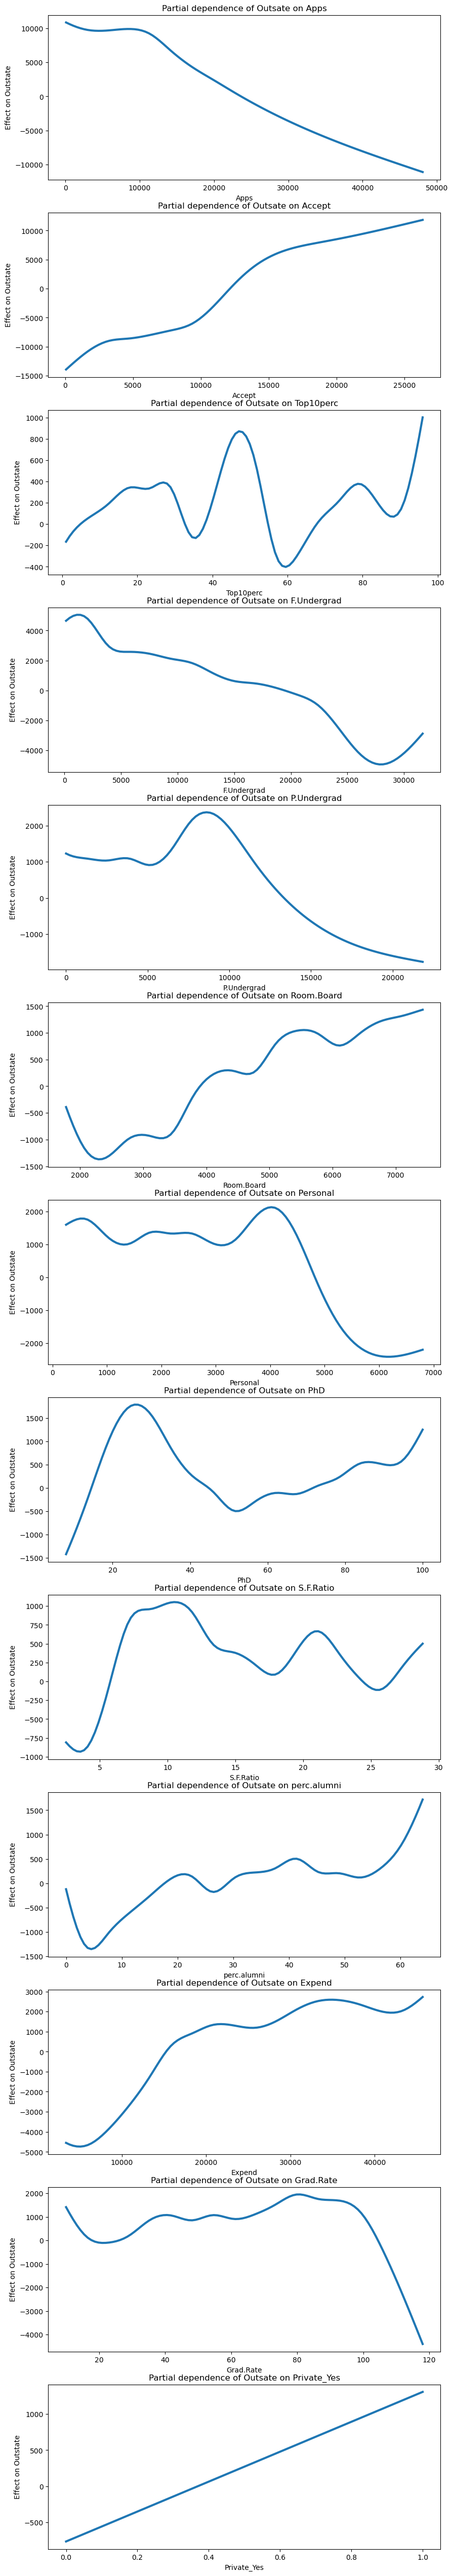

In [126]:
#Lets plot the partial dependence for each selected feature
fig, axs = subplots(len(selected_features),1, figsize=(10, 5*len(selected_features)))
for i, col in enumerate(selected_features):
    #axs[i].scatter(X_train_sel[col], y_train, fc="gray", alpha=0.5, label="Data")
    X_gam = gam.generate_X_grid(term=i) #grid of values for feature i
    pdep = gam.partial_dependence(term=i, X=X_gam) #fitted smooth
    axs[i].plot(X_gam[:,i], pdep, color="C0", lw=3)
    axs[i].set_title(f"Partial dependence of Outsate on {col}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Effect on Outstate")



##### ***(c)***. Evaluate the model obtained on the test set, and explain the results obtained

In [123]:
r2_test = gam.score(X_test_sel, y_test) # returns the coefficient of determination(Rsquared)
#r2_test
#The model explains 71% of the variance in Outstate tuition on unseen data

# you can also compute the MSE for interpretability
from sklearn.metrics import mean_squared_error
y_pred = gam.predict(X_test_sel)
mse_test = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_test)
rmse

## The response variable Outstate is tuition in USD: So on average the model's predictions are off by about $2,000 in tuition

2086.631786573335